# 6.  NonLocal Means (NLM) filter

Please implement the naive NLM to denoise the Noisy.raw with kernel sizes of 5x5, 7x7. 

Also, please apply your NLM on the three test images (lena, baboon, F16) 

to check the filtered results and make discussion about when the NLM will work well.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.image as mpimg

 Load image from drive and shows the original image

In [17]:
imgDataNoisy = np.fromfile('data/Noisy.raw', dtype='uint8')
imgDataF16 = np.fromfile('data/F16.raw', dtype='uint8')
imgDatalena = np.fromfile('data/lena.raw', dtype='uint8')
imgDataBaboon = np.fromfile('data/Baboon.raw', dtype='uint8')

In [3]:
def raw_read(imgData):
    nr = 512
    nc = 512
    nchan = 1
    c = 0 #用 c來記錄 raw檔讀取到的 index位置
    img = np.zeros((nr, nc, nchan))
    for i in range(nr):
        for j in range(nc):
            for k in range(0, nchan):
                img[i, j, k] = imgData[c]
                c=c+1
    return img

In [18]:
img_Noisy = raw_read(imgDataNoisy)
img_F16 = raw_read(imgDataF16)
img_lena= raw_read(imgDatalena)
img_Baboon= raw_read(imgDataBaboon)

# Gaussian Filter

In [5]:
'''
*Parameters:
- x, y and sigma(double): gaussian function parameters

*Return: 
- Scaler value at x,y for sigma of gaussian function
'''
# gaussian filter
def gfunc(x,y,sigma):
    return (math.exp(-(x**2 + y**2)/(2*(sigma**2))))/(2*3.14*(sigma**2))

def gaussFilter(size, sigma):
    out = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            out[i,j] = gfunc(i-size[0]//2,j-size[1]//2, sigma )
    return out/np.sum(out)

(gfw,gfh) = (3,3)
gaussianFilter = gaussFilter((gfw,gfh),1)

print("Gaussian Filter")
print(gaussianFilter)

Gaussian Filter
[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]


## convolution

In [6]:
# applies convolution to an 2d/3d matrix or numpy array on the given filter
def conv(image, filter):
    iw,ih,id = image.shape
    
    fw,fh = filter.shape    
    out = np.zeros((iw-fw+1,ih-fh+1,id))
    
    for d in range(id):
        for w in range(ih-fh+1):
            for h in range(iw-fw+1):
                out[w,h,d] = np.sum(filter*image[w:w+fh , h:h+fw , d])
    
    if id == 1:
        return np.resize(out, (out.shape[0], out.shape[1])).astype(np.uint8)
    else:
        return out.astype(np.uint8)

# show image

In [9]:
def imshow(img):
    if len(img.shape) < 3:
        plt.imshow(img, cmap="gray")
    elif img.shape[2] == 1:
        plt.imshow(np.resize(img,(img.shape[0],img.shape[1])), cmap="gray")
    else:
        plt.imshow(img)

# Non Local Mean

In [11]:
# Non Local Mean filter
'''
* create Non Local Mean Filter

- i,j: pixel value for which NLM filter will be applied
- fw,fh: Filter width and filter height
- nw,nh: neighbour width and height
- image: input image on which pixel (i,j) exist
- sigma1, sigma2:  bilateral function parameters
- nlmWFilter: bilateral Filteral
'''

def nlmfunc(i, j, fw, fh, nw, nh ,image,sigma1, sigma2, nlmWFilter):
    imgmain = image[i - fh//2:i+1 + fh//2, j - fw//2:j+1 + fw//2, :]
    
    nlmFilter = 0
    for p in range(-(nh//2), 1+(nh//2)):
        for q in range(-(nw//2), 1+(nw//2)):
            imgneighbour = image[i + p - fh//2: i+1+p + fh//2, j+q - fw//2:j+1+q + fw//2, :]
            nlmIFilter = ((imgmain - imgneighbour)**2 )/(2*(sigma1**2))
            nlmFilter += np.exp(-1*nlmIFilter)
            
    nlmFilter = nlmFilter/np.sum(nlmFilter,axis=(0,1))
    nlmFilter = nlmFilter*nlmWFilter
    nlmFilter = nlmFilter/np.sum(nlmFilter,axis=(0,1))
    return np.sum(np.multiply(imgmain, nlmFilter),axis=(0,1))

In [12]:
'''
* apply convolution on given image with the NLM filter of given size
- image: input image on which NLM filter will be applied
- nw,nh: neighbour width and height
- fw,fh: widht and height if NLM filter

'''
def nlmFilterConv(image, fw,fh, nw, nh):
    size = image.shape
    sigma1 = 20
    sigma2 = 20
    nlmWFilter1 = 2*3.14*sigma2*sigma2*gaussFilter((fw,fh), sigma2)
    if len(image.shape) < 3  or image.shape[2] == 1:
        nlmWFilter = np.resize(nlmWFilter1,(*nlmWFilter1.shape,1))
    else:
        nlmWFilter = np.stack([nlmWFilter1, nlmWFilter1, nlmWFilter1], axis=2)    

    out = np.zeros((size[0]-2*fw +1-nw//2,size[1]-2*fh +1-nh//2, size[2]))
    for i in range(nh//2, size[0]-2*fh +1-nh//2):
        for j in range(nw//2, size[1]-2*fw +1- nw//2):
            out[i,j,:] = nlmfunc(i+fw-1, j+fh-1, fw, fh, nw, nh, image, sigma1, sigma2, nlmWFilter)
        
    out[0:nh//2,:,:] = out[nh//2,:,:]
    out[:,0:nw//2,:] = out[:,nw//2,:,np.newaxis]
    if id == 1:
        return np.resize(out, (out.shape[0], out.shape[1])).astype(np.uint8)
    else:
        return out.astype(np.uint8)

Noisy

 ========================================= NLM Filter =========================================


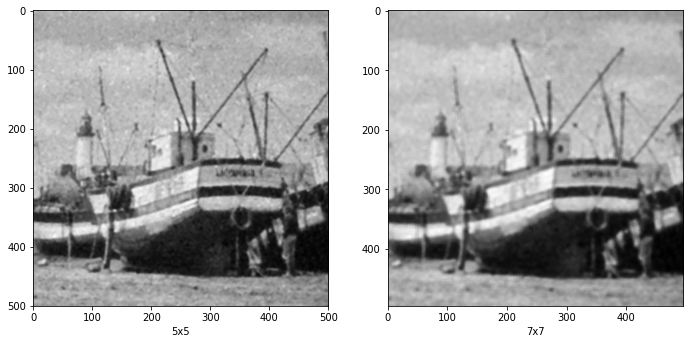

In [20]:
fig = plt.figure(1, figsize=(18, 16))
for i in range(5,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    nlmfw,nlmfh = (i,i)
    nlm_image = nlmFilterConv(img_Noisy, nlmfw,nlmfh, i, i)
    imshow(nlm_image)
plt.show()

F16

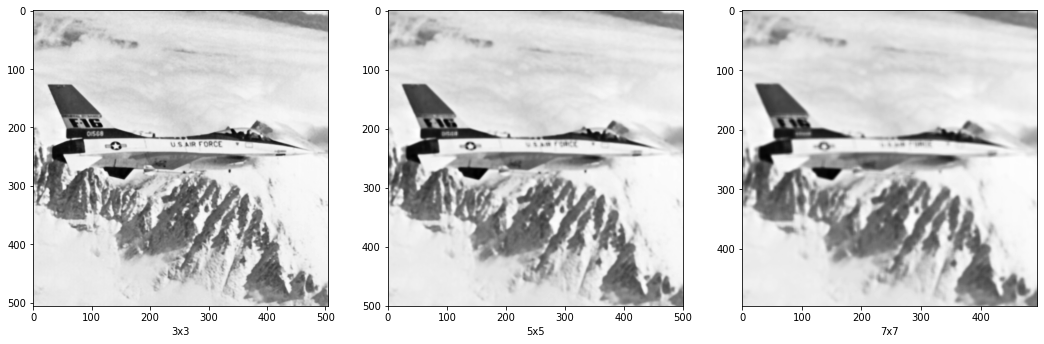

In [21]:
fig = plt.figure(1, figsize=(18, 16))
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    nlmfw,nlmfh = (i,i)
    nlm_image = nlmFilterConv(img_F16, nlmfw,nlmfh, i, i)
    imshow(nlm_image)
plt.show()

lena

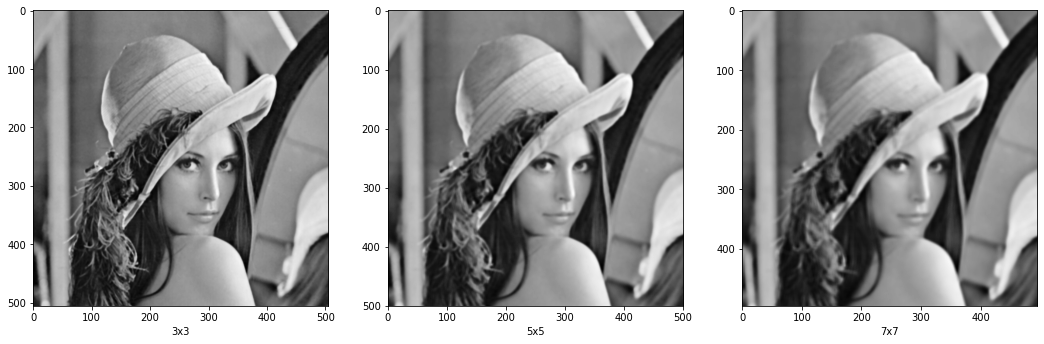

In [22]:
fig = plt.figure(1, figsize=(18, 16))
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    nlmfw,nlmfh = (i,i)
    nlm_image = nlmFilterConv(img_lena, nlmfw,nlmfh, i, i)
    imshow(nlm_image)
plt.show()

Baboon

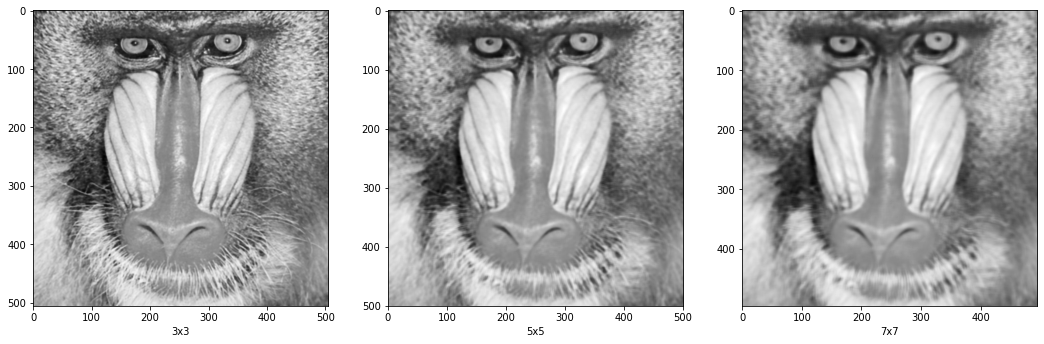

In [23]:
fig = plt.figure(1, figsize=(18, 16))
for i in range(3,8,2):
    splot = plt.subplot(130-1+((i+1)//2))
    splot.set_xlabel(str(i)+"x"+str(i))
    nlmfw,nlmfh = (i,i)
    nlm_image = nlmFilterConv(img_Baboon, nlmfw,nlmfh, i, i)
    imshow(nlm_image)
plt.show()